In [38]:
import torch
from fastprogress import master_bar, progress_bar
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import torch.nn as nn
from torch.autograd import Variable
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torchviz import make_dot, make_dot_from_trace
import random

In [39]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.dropout = nn.Dropout(p=0.2)

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first= True,dropout = 0.2)
        
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
       
        
        
        _, (hn, cn) = self.lstm(x, (h_0, c_0))
        
        y = hn.view(-1, self.hidden_size)
        
        final_state = hn.view(self.num_layers, x.size(0), self.hidden_size)[-1]
        
        out = self.fc(final_state)
       
        return out

In [40]:
history = 8
lstm = LSTM(1, 2, 1024, 2)
lstm.train()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr= 1e-3,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=100,factor =0.5 ,min_lr=1e-7, eps=1e-08)
f_lst = ['des_dx', 'x', 'dx', 'torque']
random.seed(10)

In [41]:
def create_df(f):
    df = pd.DataFrame([line.strip().split() for line in f.readlines()])
    df = df[[0, 1, 3, 6]]
    df.columns = f_lst
    df['vel_error'] = df['des_dx'].astype(float) - df['dx'].astype(float)
    return df

In [42]:
def create_xy(df, h = history):
    X = np.array(df[['x', 'vel_error']]).astype('float')
    
    X = np.array([[X[i - j] for j in range(h - 1, -1, -1)] for i in range(h - 1, len(X))])
    
    #g = np.array([[[0, 0], [0, 0], X[0]], [[0, 0], X[0], X[1]]])
    
    #X = np.concatenate([g, X])
    y = np.array(df[['torque']]).astype('float')[(h - 1):]
    return (X, y)

In [43]:
with open('/Users/tarsur909/Documents/PythonStuff/data/data1.0.txt') as f:
        df = create_df(f)

X, y = create_xy(df)
count = 1
#for n in range(1, 100):
lst = [i for i in range(1, 100)]
sample = random.sample(lst, 99)
train = []
test = []
for n in sample:
    if count <= 36:
        try: 
            with open('/Users/tarsur909/Documents/PythonStuff/data/data0.' + str(n) + '.txt') as f:
                temp_df = create_df(f) 
            tempX, tempy = create_xy(temp_df)
            X = np.concatenate([X, tempX])
            y = np.concatenate([y, tempy])
            train.append(n)
            count += 1
        except:
            continue
    else:
        try: 
            with open('/Users/tarsur909/Documents/PythonStuff/data/data0.' + str(n) + '.txt') as f:
                temp_df = create_df(f)
            test.append(n)
        except:
            continue
                

In [44]:
X.shape

(8586, 8, 2)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    
    
X_train = Variable(torch.tensor(X_train))
X_test = Variable(torch.tensor(X_test))
y_train = Variable(torch.tensor(y_train))
y_test = Variable(torch.tensor(y_test))
    
    
for i in progress_bar(range(1, 501)):
    lstm.train()
    output = lstm(X_train.float())
    optimizer.zero_grad()
        
    loss = criterion(output, y_train.float())
    loss.backward()
    optimizer.step()
        
    lstm.eval()
    valid = lstm(X_test.float())
    val_loss = criterion(valid, y_test.float())
    scheduler.step(val_loss)
    
    if i == 1 or i % 50 == 0:
        print("Epoch: %d, loss: %1.5f valid loss:  %1.5f " %(i, loss.cpu().item(),val_loss.cpu().item()))

Epoch: 1, loss: 0.15356 valid loss:  0.16607 
Epoch: 50, loss: 0.10357 valid loss:  0.09952 
Epoch: 100, loss: 0.02907 valid loss:  0.02930 
Epoch: 150, loss: 0.01772 valid loss:  0.01705 
Epoch: 200, loss: 0.01457 valid loss:  0.01398 
Epoch: 250, loss: 0.01431 valid loss:  0.01442 
Epoch: 300, loss: 0.01418 valid loss:  0.01376 
Epoch: 350, loss: 0.01384 valid loss:  0.01349 
Epoch: 400, loss: 0.01479 valid loss:  0.01401 
Epoch: 450, loss: 0.01392 valid loss:  0.01411 
Epoch: 500, loss: 0.01338 valid loss:  0.01306 


In [46]:
def graph_predictions(data, title):
    fig, axes = plt.subplots(3, 3, figsize=(20, 12))
    i = 0
    j = 0
    fig.suptitle('Graphs for ' + title + ' Data')
    
    for n in data:
        if i < 3:
    
            with open('/Users/tarsur909/Documents/PythonStuff/data/data' + str(format(n / 100.0, '.2f')) + '.txt') as f:
                df = create_df(f)

            X, y = create_xy(df)
            lstm.eval()
            X = Variable(torch.tensor(X))
            whole = lstm(X.float())
            whole = whole.detach().numpy()
            whole = whole.flatten()
            result = pd.DataFrame(data = {'predictions': whole, 'real': y.flatten()})
    
            sns.lineplot(ax = axes[i, j], data = result).set(title='Des Vel of ' + str(format(n / 100.0, '.2f')))
    
            j += 1
            
            if j > 2:
                j = 0
                i += 1
        else: 
            break
            
        

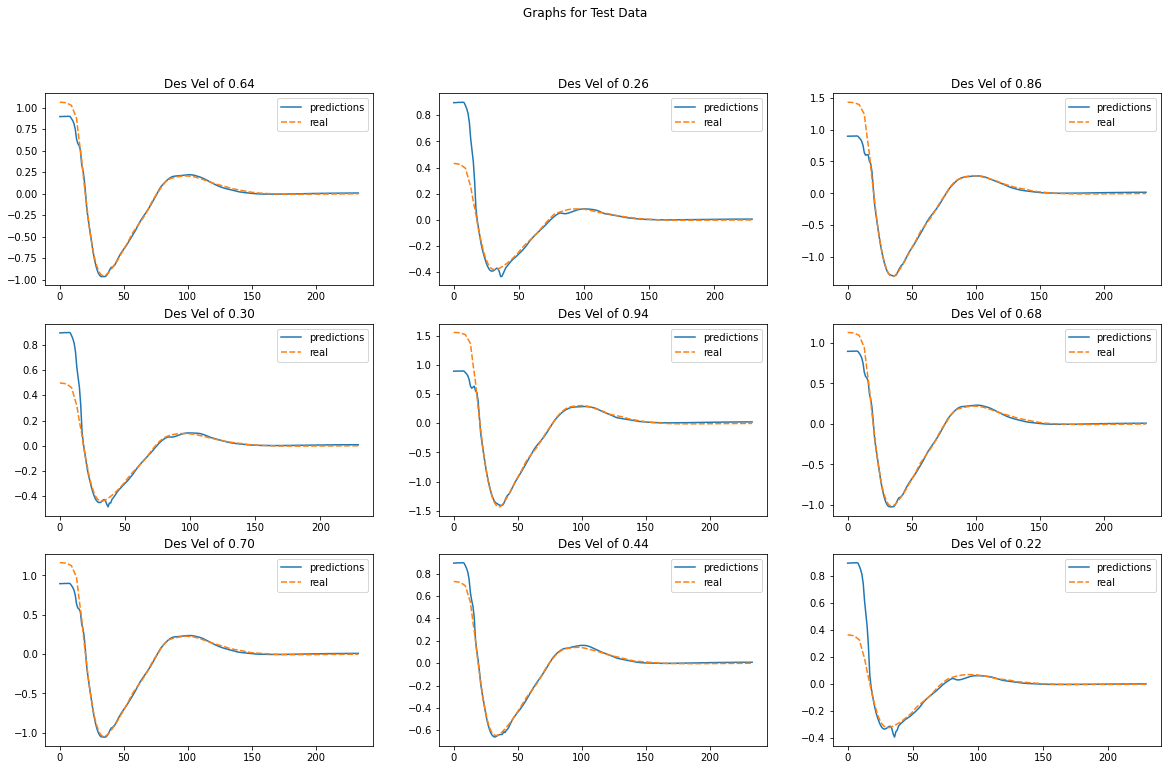

In [47]:
graph_predictions(test, 'Test')

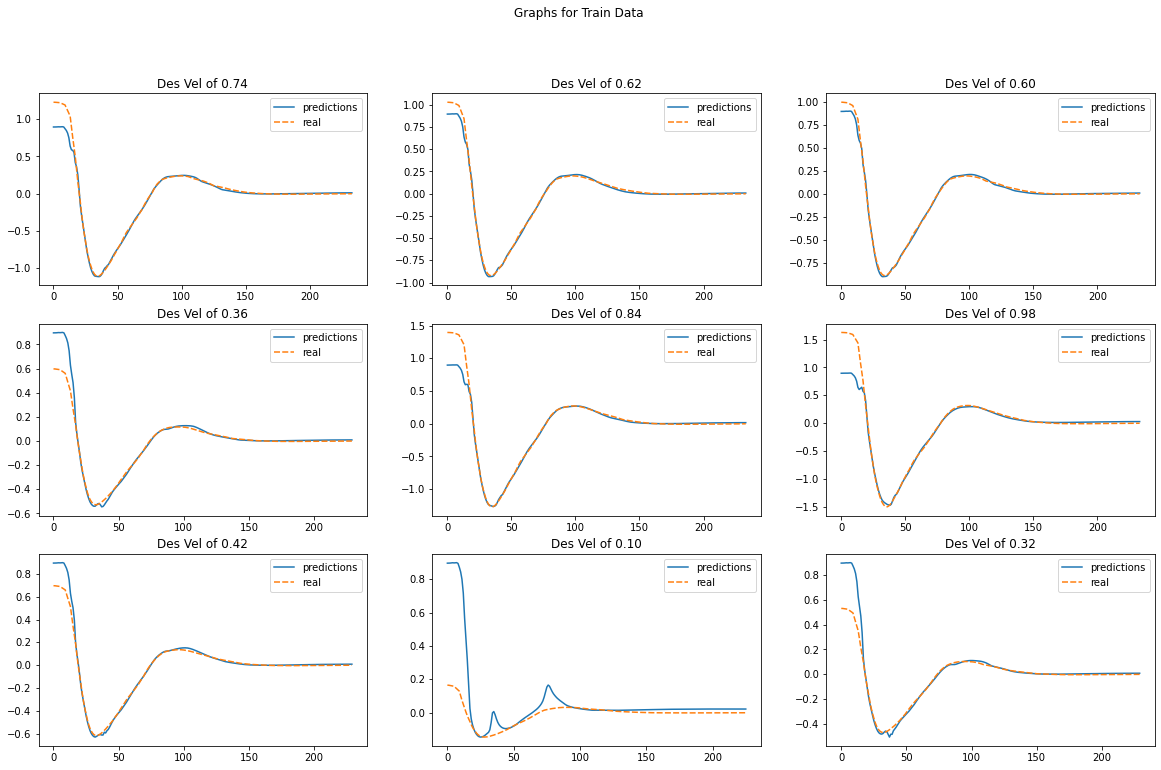

In [48]:
graph_predictions(train, 'Train')